# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# Our VAE class
from VariationalModel import *

# Set up

## Tracking Layers

In [3]:
activations = {}

def get_activation(name):
    """Create a hook that saves the layer output."""
    def hook(module, inputs, output):
        activations[name] = output.detach()
    return hook


def setup_hooks(model):
    """Register forward hooks on encoder, decoder, latent, and output layers."""
    activations.clear()

    # Encoder layers
    for i, layer in enumerate(model.Encoder):
        layer.register_forward_hook(get_activation(f"encoder_layer_{i+1}"))

    # Decoder layers
    for i, layer in enumerate(model.Decoder):
        layer.register_forward_hook(get_activation(f"decoder_layer_{i+1}"))

    # Latent space (Identity module)
    model.LatentSpace.register_forward_hook(get_activation("latent_space"))

    # Output space (Identity module)
    model.OutputSpace.register_forward_hook(get_activation("output_space"))

## Mutual Info (KDE method)

In [4]:
def kde_entropy(data, sigma=0.1):

    # If data are on gpu we need to move to cpu
    if isinstance(data, torch.Tensor): data = data.detach().cpu().numpy()

    N, d = data.shape

    data_sq = np.sum(data**2, axis=1, keepdims=True)
    dists_sq = data_sq + data_sq.T - 2 * np.dot(data, data.T)

    kernel = np.exp(-dists_sq / (2 * sigma**2))
    density = np.mean(kernel, axis=1)

    return -np.mean(np.log(density + 1e-10))


def MutualInfo(layer_data, target_data, sigma=0.1):
    h_layer = kde_entropy(layer_data, sigma)
    h_target = kde_entropy(target_data, sigma)

    joint = np.concatenate([layer_data, target_data], axis=1)
    h_joint = kde_entropy(joint, sigma)

    return h_layer + h_target - h_joint

In [5]:
def VAE_info(model, dataset, device='cpu', num_samples=1000):
    model.eval()
    model.to(device)

    loader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True)
    inputs, _ = next(iter(loader))
    inputs = inputs.to(device)

    # One forward pass to populate activations
    with torch.no_grad():
        outputs, z = model(inputs)

    X_data = inputs.view(inputs.size(0), -1).detach().cpu().numpy()
    Z_data = activations["latent_space"].detach().cpu().numpy()
    Y_data = activations["output_space"].detach().cpu().numpy()

    mi = {"encoder": [], "decoder": []}

    # Encoder MI
    for i in range(1, len(model.Encoder) + 1):
        act = activations[f"encoder_layer_{i}"].detach().cpu().numpy()
        mi["encoder"].append((
            MutualInfo(act, X_data),
            MutualInfo(act, Z_data)
        ))

    # Decoder MI
    for i in range(1, len(model.Decoder) + 1):
        act = activations[f"decoder_layer_{i}"].detach().cpu().numpy()
        mi["decoder"].append((
            MutualInfo(act, Z_data),
            MutualInfo(act, Y_data)
        ))

    return mi

# Dataset

In [6]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

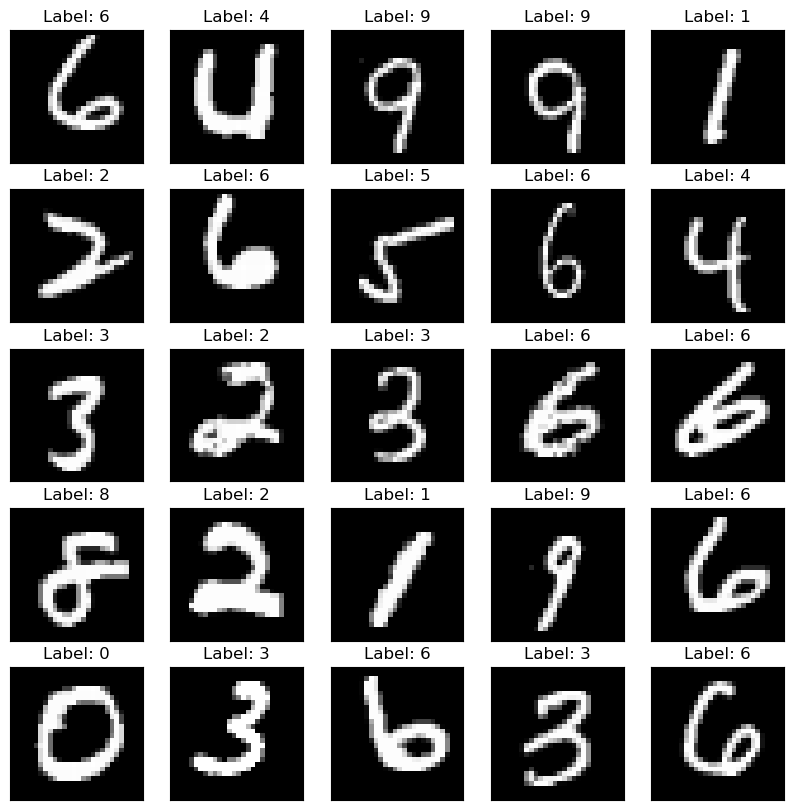

In [7]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [8]:
#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

In [9]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=256, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# VAE model

## Set up model

In [10]:
model = VariationalAutoEncoder(latentDim = 10, hiddenDim=[200, 150, 100])

In [11]:
loss_fn = torch.nn.MSELoss()

lr = 5e-4
parameToOptimize = [
   {'params': model.parameters()}
]

optim = torch.optim.Adam(parameToOptimize, lr = lr)
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

model.to(device)

Selected device: cuda


VariationalAutoEncoder(
  (Encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=150, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=150, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (LatentLayerMu): Linear(in_features=100, out_features=10, bias=True)
  (LatentLayerSigma): Linear(in_features=100, out_features=10, bias=True)
  (LatentSpace): Identity()
  (Decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=150, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=150, out_features=200, bias=True)
      (1): ReLU()
    )
  )
  (OutputLayer): Linear(in_features=200, out_features=784, bias=True)
  (OutputSpace): Ident

## Training Model

In [12]:
history_encoder = []
history_decoder = []

def Training(model, num_epochs=10, showImage=False):
    setup_hooks(model)

    for epoch in range(num_epochs):
        model.train()
        losses = []

        for images, _ in tqdm(trainDataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)

            outputs, z = model(images) #outputs, z, mean, std
            targets = images.view(images.size(0), -1)

            loss = loss_fn(outputs, targets)

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.detach().cpu().numpy())

        # Computing Mutual Info
        res = VAE_info(model, trainDataset, device)
        history_encoder.append(res['encoder'])
        history_decoder.append(res['decoder'])

        avg_loss = np.mean(losses)
        print(f"TRAIN — Epoch {epoch+1}/{num_epochs} — loss: {avg_loss:.4f}")

        if showImage:
            model.eval()

            img = testDataset[0][0].unsqueeze(0).to(device)

            with torch.no_grad():
                recon = model(img)[0]

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))

            axs[0].imshow(img.cpu().squeeze(), cmap='gist_gray')
            axs[0].set_title("Original image")

            axs[1].imshow(recon.cpu().squeeze().reshape(28, 28), cmap='gist_gray')
            axs[1].set_title(f"Reconstruction (epoch {epoch+1})")

            plt.tight_layout()
            plt.show()
            plt.close()

    return np.mean(losses)

Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 58.71it/s]


TRAIN — Epoch 1/10 — loss: 0.0808


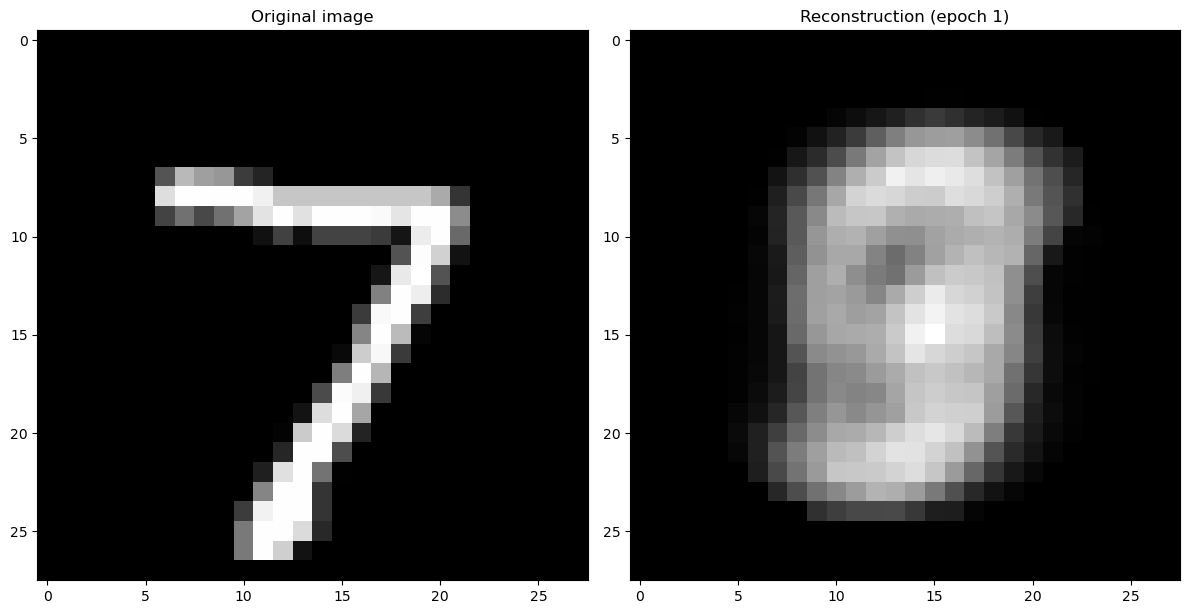

Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 58.13it/s]


TRAIN — Epoch 2/10 — loss: 0.0525


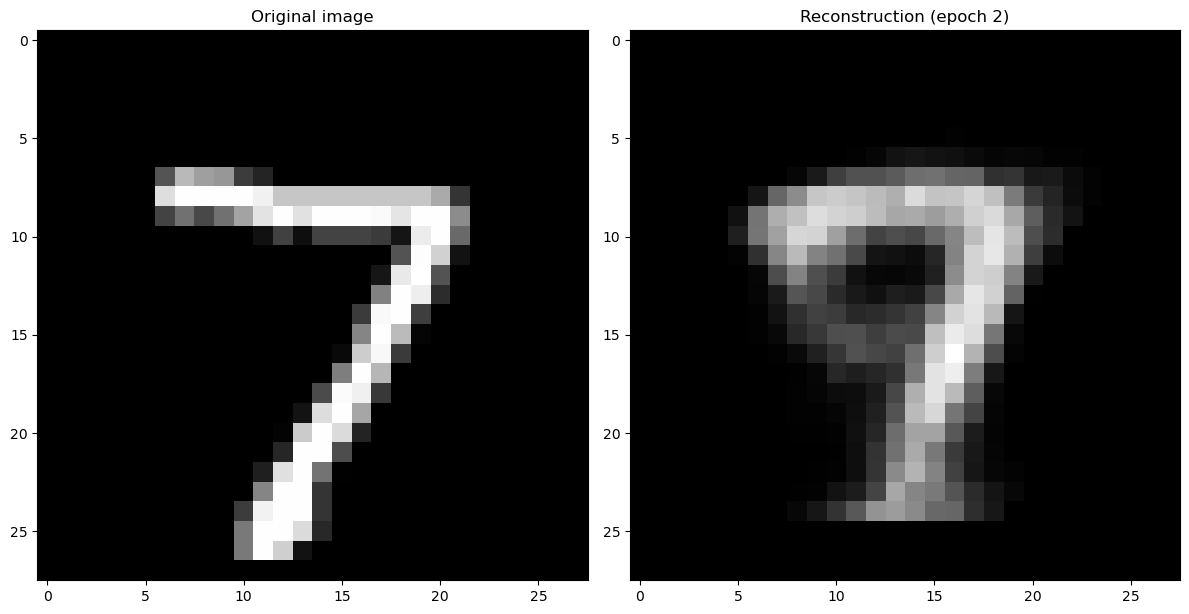

Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 59.96it/s]


TRAIN — Epoch 3/10 — loss: 0.0396


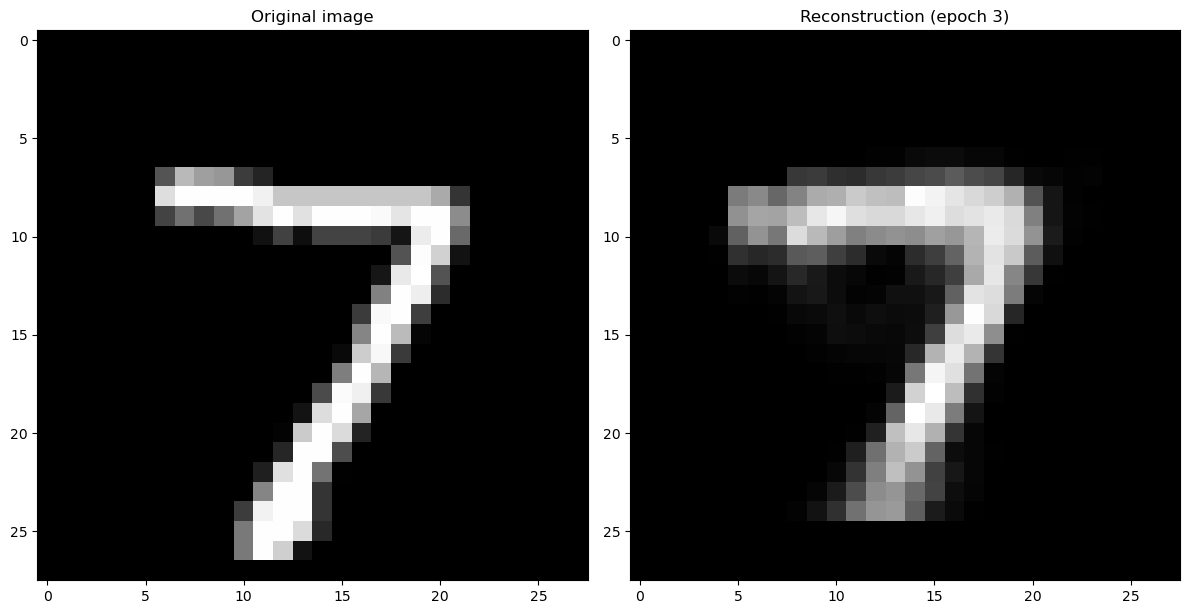

Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 58.09it/s]


TRAIN — Epoch 4/10 — loss: 0.0330


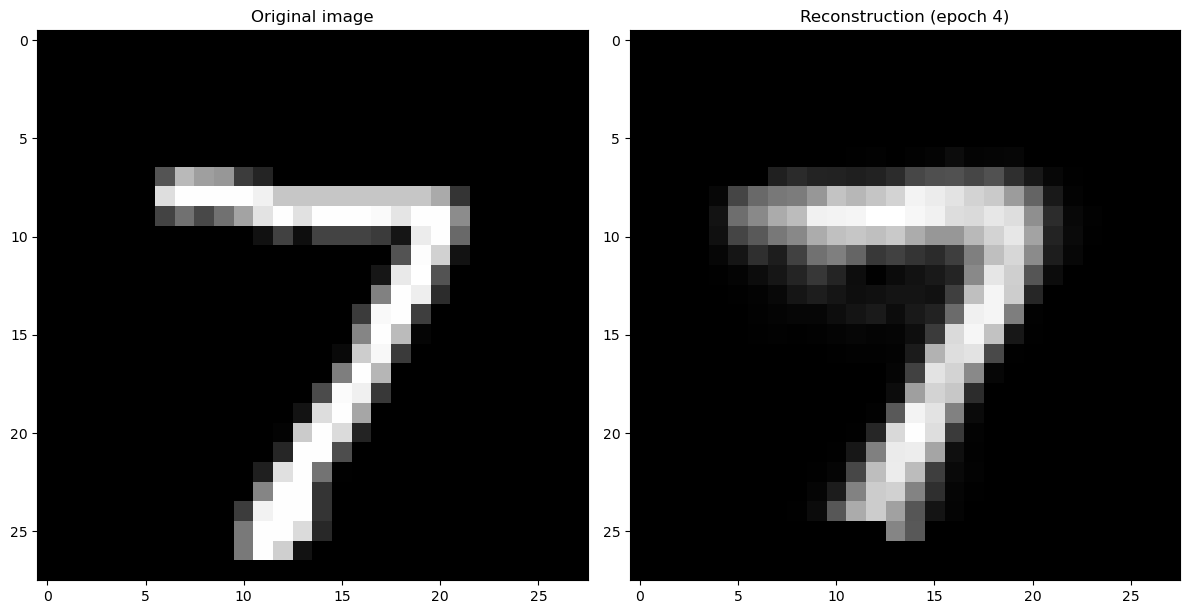

Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 61.01it/s]


TRAIN — Epoch 5/10 — loss: 0.0306


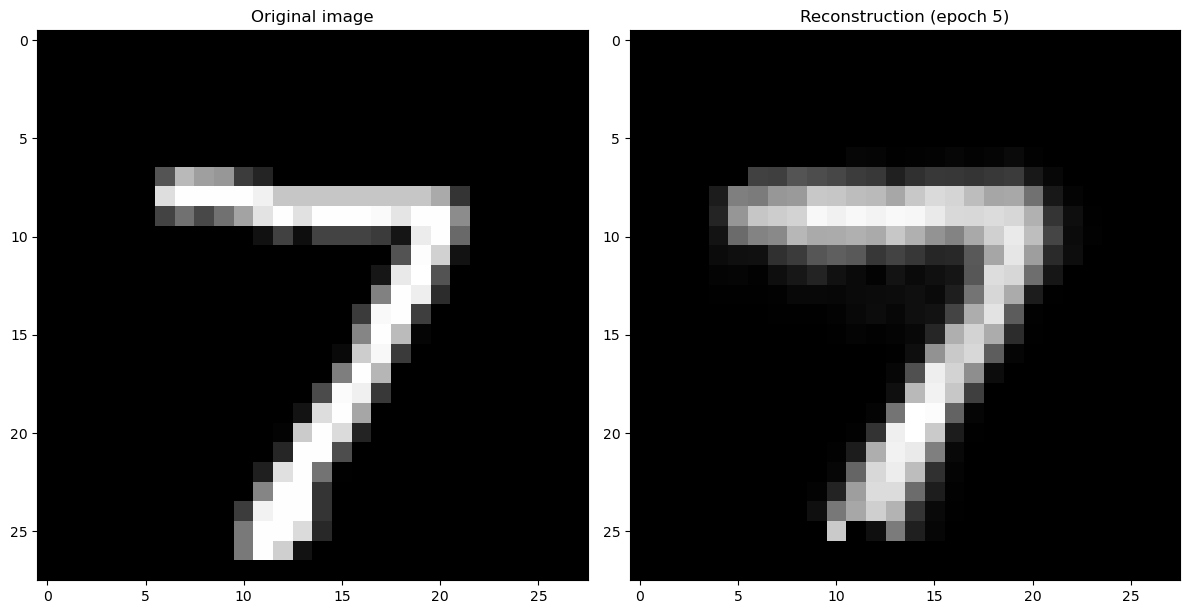

Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 62.40it/s]


TRAIN — Epoch 6/10 — loss: 0.0287


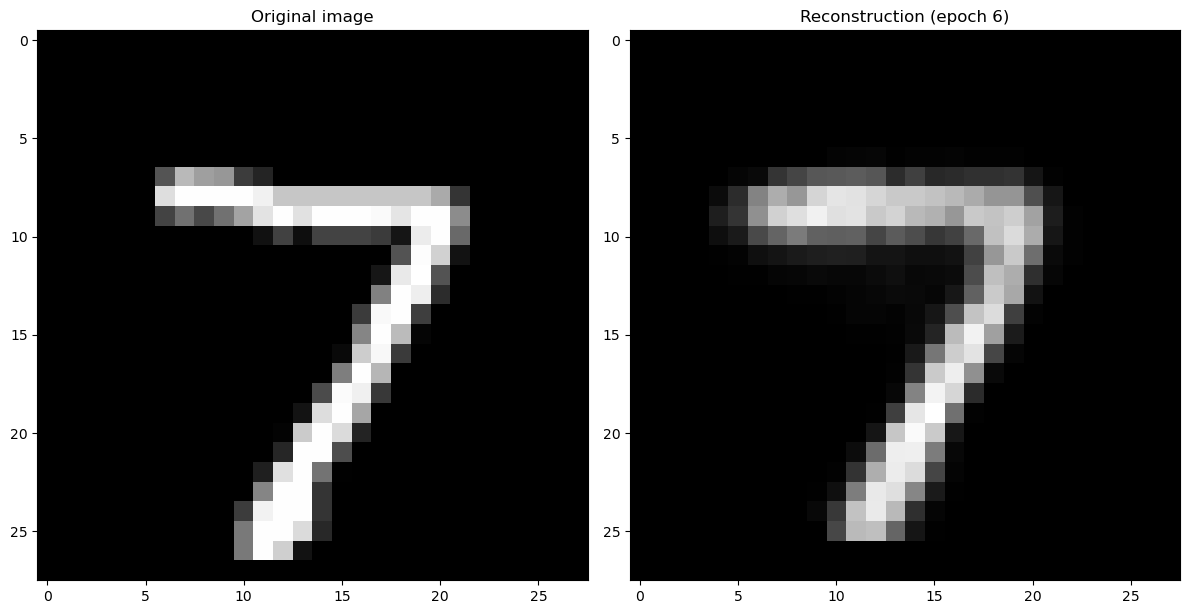

Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 59.53it/s]


TRAIN — Epoch 7/10 — loss: 0.0269


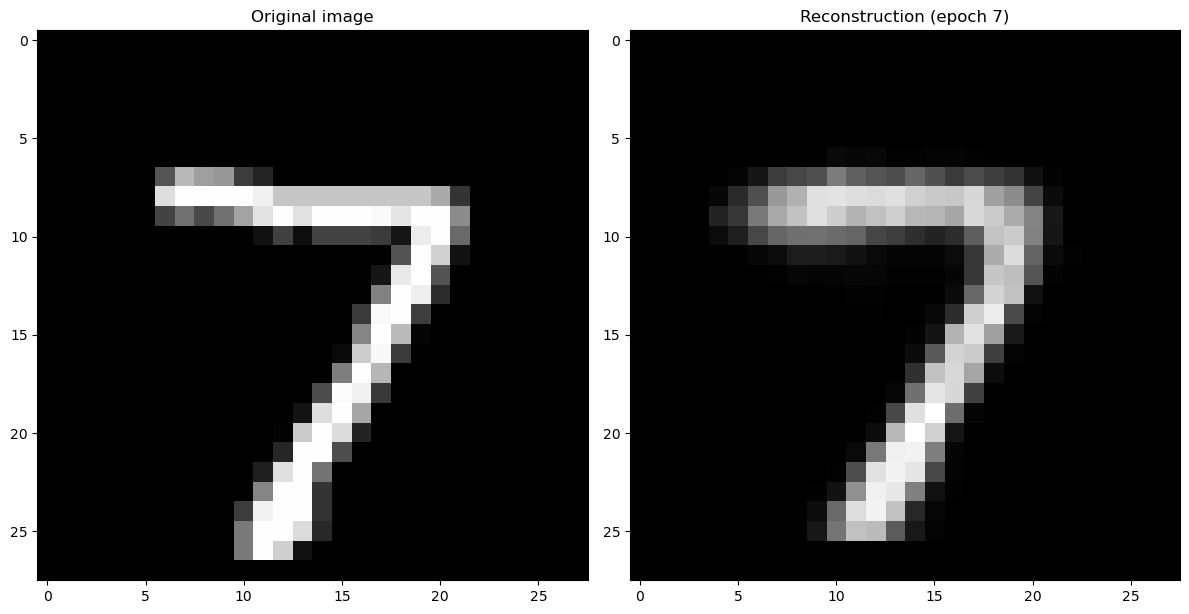

Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 59.30it/s]


TRAIN — Epoch 8/10 — loss: 0.0258


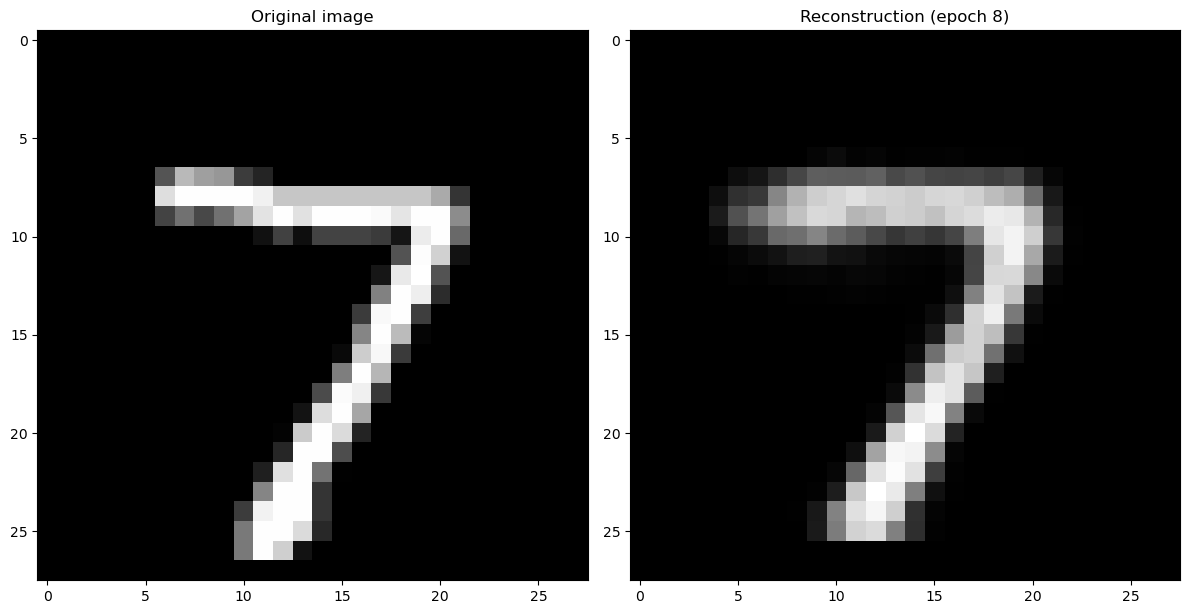

Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 59.17it/s]


TRAIN — Epoch 9/10 — loss: 0.0247


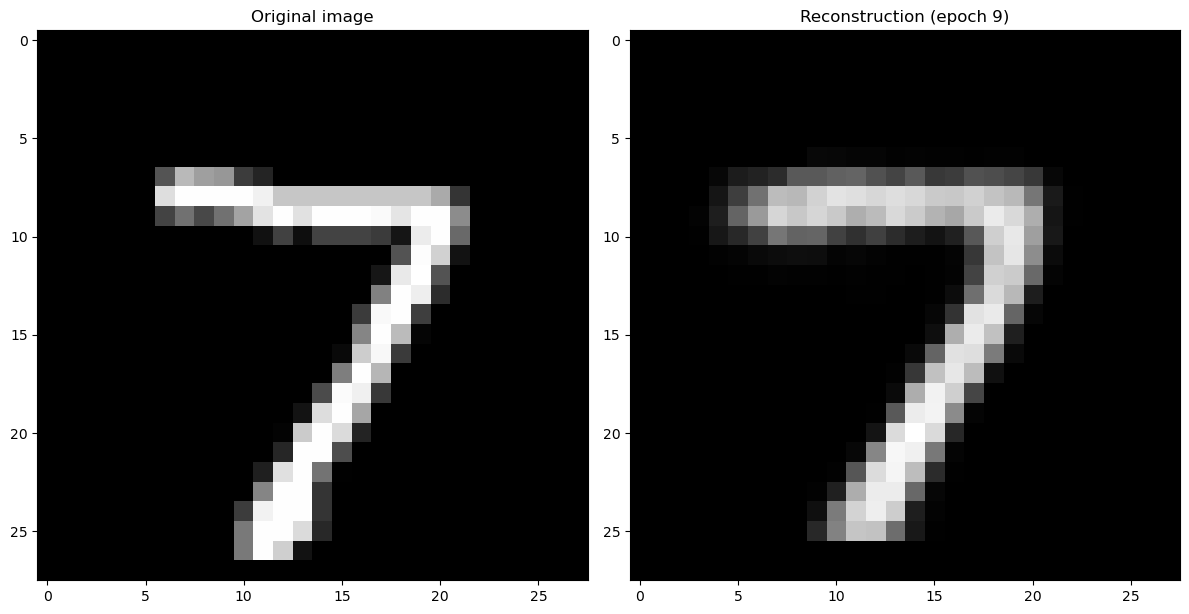

Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:03<00:00, 60.97it/s]


TRAIN — Epoch 10/10 — loss: 0.0235


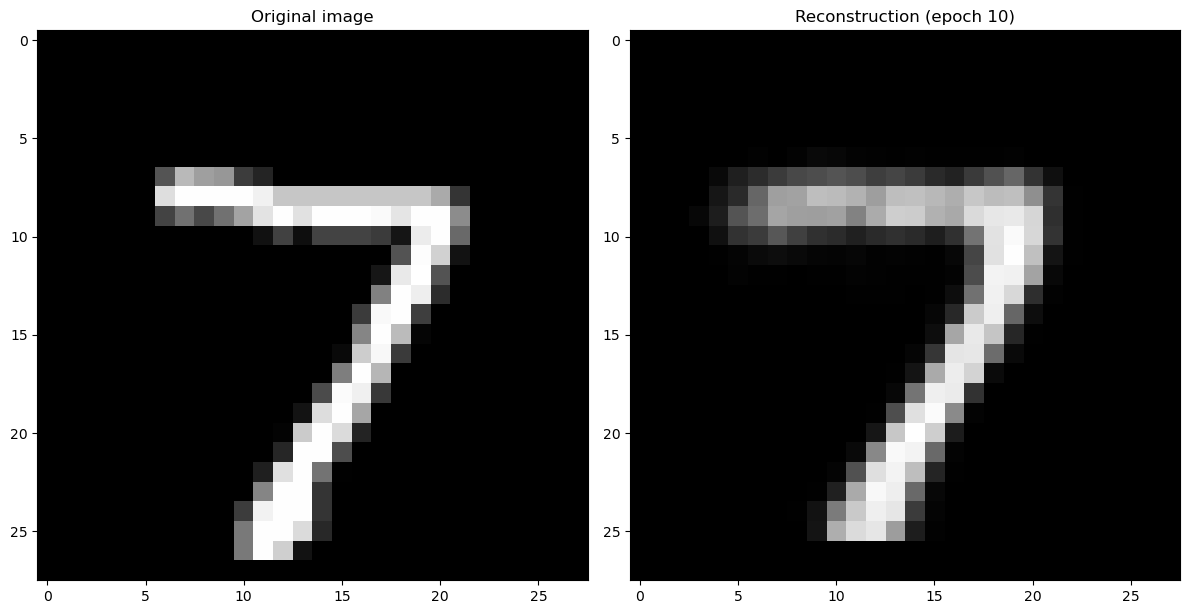

In [13]:
epoch = 10
final_loss = Training(model, num_epochs=epoch, showImage=True)

# Results

## Debug

In [14]:
activations

{'encoder_layer_1': tensor([[1.8381, 1.4325, 0.0000, 1.2086, 0.2708, 0.0000, 2.0810, 0.0000, 0.0000,
          0.5513, 0.2278, 1.1152, 0.0000, 0.0000, 0.0000, 1.0725, 0.9292, 1.0882,
          1.0036, 0.0000, 0.0000, 0.0000, 0.0000, 0.4960, 1.8027, 0.6973, 0.9737,
          1.9047, 2.1486, 0.7085, 0.0000, 1.5436, 0.0000, 0.7786, 1.3387, 0.0116,
          0.7640, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5820, 1.7055, 0.4593,
          1.1599, 0.4861, 0.0000, 0.0000, 2.0265, 0.0000, 0.3689, 0.8638, 0.0000,
          1.0959, 0.0000, 1.0337, 0.0000, 0.0000, 0.8058, 0.9288, 0.0000, 0.3049,
          1.0688, 0.2059, 0.0000, 3.3517, 2.6539, 0.0000, 0.0000, 0.0000, 0.9656,
          0.0000, 0.0000, 0.2004, 1.1752, 1.2047, 1.3694, 1.3455, 1.3149, 0.1799,
          0.9722, 0.0000, 0.4174, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.6284, 2.0212, 1.4968, 0.0000, 0.5373, 0.9094, 0.0000, 0.0000, 1.0312,
          1.1289, 0.0000, 0.9420, 1.3422, 0.9244, 0.0000, 0.9358, 1.1034, 0.000

In [15]:
a = activations['decoder_layer_1'].detach().cpu().numpy()[0]
print(len(a),"\n",a)

100 
 [ 8.52688     8.164015   11.151487    5.747407    2.2988667   3.153946
  0.40264183  0.          1.5238914   0.3126871   0.          2.562572
 11.899242    6.901142    1.702556    0.          7.6204767   4.9824176
  4.748797    1.0889343   1.5171561   8.4336815   1.853104    1.7979467
 12.652687    0.         15.414741    0.         13.984562    3.3538048
  4.420197    1.4752963  10.419467    0.          0.          7.13236
  1.6333154   1.9920729   0.61961657  4.300405    0.          0.
  0.          0.          7.635133    0.          1.835464    0.
  2.5282307   9.664284    9.736051    6.407175    2.7032883   9.917774
  0.          0.14301327  0.          7.789612    9.920169    0.
  0.          0.54275566  0.          1.1213253   5.5369205   9.699339
 10.32838     0.          2.376926    7.265727    2.4238527   0.
  1.5015738   2.1539204   3.444754    3.4443765   0.15605749  8.554166
  4.0498424   1.5565242  10.148504    5.600241    1.1828454   5.9937663
  0.          4.98484

In [16]:
history_encoder

[[(np.float32(6.9077168), np.float32(6.9077196)),
  (np.float32(6.907785), np.float32(6.9071608)),
  (np.float32(6.905816), np.float32(6.906207))],
 [(np.float32(6.907658), np.float32(6.90789)),
  (np.float32(6.908445), np.float32(6.907707)),
  (np.float32(6.907883), np.float32(6.907844))],
 [(np.float32(6.9077296), np.float32(6.9079876)),
  (np.float32(6.90808), np.float32(6.9072704)),
  (np.float32(6.9061856), np.float32(6.9070835))],
 [(np.float32(6.907657), np.float32(6.9078)),
  (np.float32(6.907826), np.float32(6.907183)),
  (np.float32(6.9041653), np.float32(6.9077406))],
 [(np.float32(6.9076676), np.float32(6.907597)),
  (np.float32(6.9078965), np.float32(6.9069333)),
  (np.float32(6.902843), np.float32(6.9062467))],
 [(np.float32(6.9077325), np.float32(6.907684)),
  (np.float32(6.9068704), np.float32(6.9076986)),
  (np.float32(6.9028444), np.float32(6.9086356))],
 [(np.float32(6.907782), np.float32(6.907651)),
  (np.float32(6.9070005), np.float32(6.9066834)),
  (np.float32(6.9

In [17]:
history_decoder

[[(np.float32(6.907333), np.float32(5.8199825)),
  (np.float32(6.90815), np.float32(5.820971)),
  (np.float32(6.9049053), np.float32(5.81646))],
 [(np.float32(6.9076147), np.float32(6.892412)),
  (np.float32(6.907968), np.float32(6.8938212)),
  (np.float32(6.907613), np.float32(6.889823))],
 [(np.float32(6.907844), np.float32(6.901426)),
  (np.float32(6.908794), np.float32(6.9032826)),
  (np.float32(6.906668), np.float32(6.899863))],
 [(np.float32(6.908351), np.float32(6.899285)),
  (np.float32(6.906008), np.float32(6.8993654)),
  (np.float32(6.907117), np.float32(6.8967843))],
 [(np.float32(6.906888), np.float32(6.89809)),
  (np.float32(6.906857), np.float32(6.898228)),
  (np.float32(6.9119573), np.float32(6.90249))],
 [(np.float32(6.9075246), np.float32(6.8999095)),
  (np.float32(6.9086566), np.float32(6.8996897)),
  (np.float32(6.9088855), np.float32(6.9028215))],
 [(np.float32(6.906698), np.float32(6.895135)),
  (np.float32(6.909286), np.float32(6.897723)),
  (np.float32(6.905537),

## Utilities Mutual Info

In [20]:
def PlotInfoPlane(mi_history_encoder, mi_history_decoder, title_suffix=""):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    epochs = len(mi_history_encoder)
    cmap = plt.get_cmap('gnuplot')

    # Colors from epoch 1 to epoch N
    colors = [cmap(i) for i in np.linspace(0, 1, epochs)]

    # ---------------- ENCODER ----------------
    ax = axes[0]
    n_layers = len(mi_history_encoder[0])

    for l in range(n_layers):
        x = [e[l][0] for e in mi_history_encoder]
        y = [e[l][1] for e in mi_history_encoder]
        ax.plot(x, y, color='gray', alpha=0.3)
        ax.scatter(x, y, c=colors, s=20)

    ax.set_xlabel("I(Layer; Input)")
    ax.set_ylabel("I(Layer; Latent Z)")
    ax.set_title(f"Encoder information plane {title_suffix}")

    # ---------------- DECODER ----------------
    ax = axes[1]
    n_layers = len(mi_history_decoder[0])

    for l in range(n_layers):
        x = [e[l][0] for e in mi_history_decoder]
        y = [e[l][1] for e in mi_history_decoder]
        ax.plot(x, y, color='gray', alpha=0.3)
        ax.scatter(x, y, c=colors, s=20)

    ax.set_xlabel("I(Layer; Latent Z)")
    ax.set_ylabel("I(Layer; Output)")
    ax.set_title(f"Decoder information plane {title_suffix}")

    # ---------------- COLORBAR ----------------
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])

    cbar = plt.colorbar(
        sm,
        ax=axes.ravel().tolist(),
        label="Training epoch"
    )

    # Set ticks from 1 to epoch
    cbar.set_ticks(np.linspace(0, 1, epoch))
    cbar.set_ticklabels(range(1, epoch + 1))

    plt.show() 

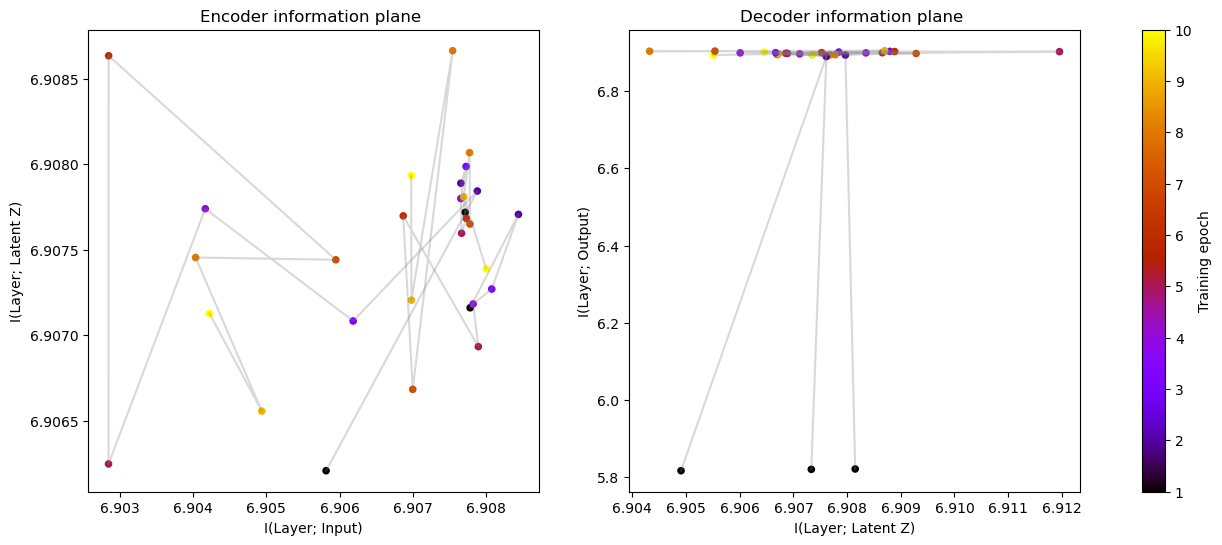

In [21]:
PlotInfoPlane(history_encoder, history_decoder)